<a href="https://colab.research.google.com/github/jayant2014/pnemumonia-prediction/blob/master/Chest_X_Ray_Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

##Load Data##

In [0]:
import os
from pathlib import Path
from zipfile import ZipFile

In [0]:
os.environ['KAGGLE_USERNAME'] = "jayant2014" 
os.environ['KAGGLE_KEY'] = "4689e2492d427c5822d6e8c0a86ed2af" 
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [0]:
# Extract the zip file
zf = ZipFile('chest-xray-pneumonia.zip', 'r')
zf.extractall()
zf.close()

In [0]:
!ls /content

In [0]:
zf = ZipFile('chest_xray.zip', 'r')
zf.extractall()
zf.close()

In [0]:
!ls /content/chest_xray
!ls /content/chest_xray/train
!ls /content/chest_xray/test/NORMAL | head -n 5
!ls /content/chest_xray/test/PNEUMONIA | head -n 5

In [0]:
train_path = "/content/chest_xray/train/"
test_path = "/content/chest_xray/test/"
val_path = "/content/chest_xray/val/"

# useful for getting number of classes
folders = glob('/content/chest_xray/train/*')

norm = 'NORMAL'
pnem = 'PNEUMONIA'

# Training Samples
# Number of chest X-RAYS which show Pneumonia
P = Path(train_path + norm + "/")
temp = list(P.glob("*.jpeg"))
print("Pneumonia Training Samples - %i " % len(temp))

# Number of chest X-RAYS which are normal
P = P = Path(train_path + pnem + "/")
temp = list(P.glob("*.jpeg"))
print("Normal Training Samples - %i " % len(temp))

# Testing Samples
# Number of chest X-RAYS which show Pneumonia
P = Path(test_path + norm + "/")
temp = list(P.glob("*.jpeg"))
print("Pneumonia Testing Samples - %i " % len(temp))

# Number of chest X-RAYS which are normal
P = P = Path(test_path + pnem + "/")
temp = list(P.glob("*.jpeg"))
print("Normal Testing Samples - %i " % len(temp))

IMAGE_SIZE = [224, 224]

In [0]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [0]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [0]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

In [0]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [0]:
# view the structure of the model
model.summary()

In [0]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [0]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

In [0]:
# fit the model
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

In [0]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

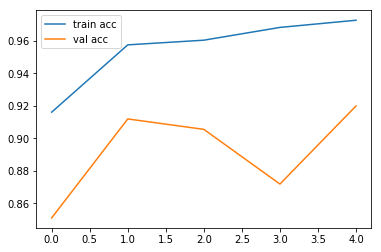

<Figure size 432x288 with 0 Axes>

In [39]:
# plot the accuracy
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [0]:
# save it as a h5 file

import tensorflow as tf
from keras.models import load_model

model.save('model_vgg19.h5')

In [0]:
# Similary you can use the same template for Vgg 19, Resnet50, Mobilenet. All you have to import the library. Below are the examples

from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3

##Predicting Models

In [0]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
model = load_model('model_vgg19.h5')

In [44]:
!ls /content/chest_xray/val/PNEUMONIA | head -n 5

person1946_bacteria_4874.jpeg
person1946_bacteria_4875.jpeg
person1947_bacteria_4876.jpeg
person1949_bacteria_4880.jpeg
person1950_bacteria_4881.jpeg


In [0]:
img_path = val_path + 'PNEUMONIA/person1946_bacteria_4874.jpeg'

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)